In the file "ML_forecasting_univariate" I tested the desired models in a univariate scenario. Therefore, I only used the value of the benchmark indices "STOXX Europe 600".

This notebook aims to get this process on the next stage by implementing these models for all variables or indices, resp.

In [38]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score
import sklearn

In [39]:
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)
ts = ts.astype('float32')
#ts.plot(label='Price')

In [76]:
train, test = ts.split_after(0.8)

### Multivariate Shrinkage methods:
- Linear regression

In [77]:
# linear regression model
linear_regression = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_regression.fit(train)
linear_forecast = linear_regression.predict(len(test))

In [78]:
# plotting the results of the linear regression model
#for col in linear_forecast.columns:
#    linear_forecast[col].plot(label=f'{col}_prediction')
#    ts[col].plot(label=f'{col}_actual')

### Multivariate Dimensionality reduction methods:
- CCA

In [79]:
cca = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.CCA(n_components=1))
cca.fit(train)
cca_forecast = cca.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [45]:
#cca_forecast.plot(label='prediction')
#ts.plot(label='actual');

### Multivariate Nonlinear ML methods
- Random Forest

In [80]:
# random forest model
random_forest = RandomForest(lags=100, output_chunk_length=1, n_estimators=100)
random_forest.fit(train)
random_forest_forecast = random_forest.predict(len(test))

In [81]:
#random_forest_forecast.plot(label='prediction')
#ts.plot(label='actual');

#### Returns
Now we need to compute this whole process with return values, such that we can transpose a forecast relative comparison in table format

In [102]:
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)
returns = ts['STOXX Europe 600'].pd_dataframe().pct_change().dropna()

In [103]:
returns_cum = (returns + 1).cumprod()
returns_cum.tail()

component,STOXX Europe 600
time,
2021-09-01,5.716808
2021-10-01,5.472414
2021-11-01,5.786189
2021-12-01,5.689488
2022-01-01,5.920590


In [104]:
returns_cum = returns_cum.astype('float32')
returns_cum_ts = TimeSeries.from_dataframe(returns_cum)

In [105]:
train_returns, test_returns = returns_cum_ts.split_after(0.8)

In [106]:
# linear regression model
returns_linear_regression = LinearRegressionModel(lags=1, output_chunk_length=1)
returns_linear_regression.fit(train_returns)
returns_linear_forecast = returns_linear_regression.predict(len(test))

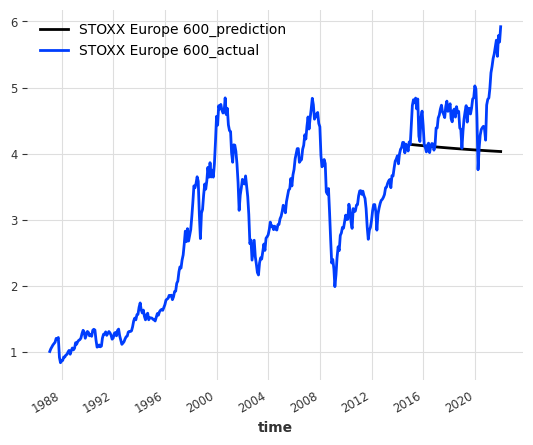

In [107]:
# plotting the results of the linear regression model
for col in returns_linear_forecast.columns:
    returns_linear_forecast[col].plot(label=f'{col}_prediction')
    returns_cum_ts[col].plot(label=f'{col}_actual')

In [116]:
# create table including the actual and predicted values tail
x=returns_cum_ts.pd_dataframe().tail()
y=returns_linear_forecast.pd_dataframe().tail()
# column names
x.columns=['actual benchmark']
y.columns=['predicted benchmark']
z=pd.concat([x,y], axis=1)
z


,actual benchmark,predicted benchmark
time,,
2021-09-01,5.716808,4.034739
2021-10-01,5.472414,4.033796
2021-11-01,5.786189,4.032861
2021-12-01,5.689487,4.031933
2022-01-01,5.920589,4.031012
